In [1]:
import pandas as pd

import os

import copy

import random

import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'data'

df = pd.read_csv('data\\Friends_processed.csv')
df

,Text,Speaker
0,central perk.,break
1,there's nothing to tell! he's just some guy i ...,monica
2,"c'mon, you're going out with the guy! there's ...",joey
3,so does he have a hump? a hump and a hairpiece?,chandler
4,"wait, does he eat chalk?",phoebe
...,...,...
63484,"yeah, yeah, oh!",ross
63485,"oh! oh, i'm so happy.",rachel
63486,then i'm happy too.,ross
63487,estelle's memorial service. joey is giving a s...,break


Задаем основные параметры обработки:

- BREAK_LABEL - метка разрыва диалогов
- CHARACT - выбранный персонаж
- CONT_DEPTH - глубина контекста

In [3]:
BREAK_LABEL = 'break'
CHARACT = 'chandler'
CONT_DEPTH = 8

Обрабатываем реплики персонажей следующим образом: сначала записываются все реплики, предшествующие реплике выбранного персонажа, далее пишется реплика персонажа. Процедура повторяется до тех пор, пока не будет достигнута метка break или заданная глубина контекста CONT_DEPTH.

Если диалог начинается с реплики выбранного персонажа, она не добавляется в датасет т.к. у нее нет предшествующей реплики

In [33]:
data = []
bank_repl = []
dialog = []

for index, row in tqdm(df.iterrows()):
    if row['Speaker'] == CHARACT and len(bank_repl) > 0:        
        question = ''
        for i in range(min(len(bank_repl), REPL_DEPTH), 0, -1):
            question = question + ' ' + str(bank_repl[-i])
        dialog.append(question)
        dialog.append(row['Text'])        
        bank_repl.clear()
    else:    
        bank_repl.append(row['Text'])
        
    if len(dialog) == CONT_DEPTH:
        data.append(copy.deepcopy(dialog))
        dialog = dialog[2:]
    
    if row['Speaker'] == BREAK_LABEL:
        if len(dialog) > 1:
            data.append(copy.deepcopy(dialog))
        dialog.clear()
        bank_repl.clear()

63489it [00:03, 17737.18it/s]


Выводим несколько диалогов для проверки правильности работы алгоритма

In [34]:
data[0]

[" there's nothing to tell! he's just some guy i work with! c'mon, you're going out with the guy! there's gotta be something wrong with him!",
 'so does he have a hump? a hump and a hairpiece?',
 " just, 'cause, i don't want her to go through what i went through with carl- oh! okay, everybody relax. this is not even a date. it's just two people going out to dinner and- not having s*x.",
 'sounds like a date to me.']

In [35]:
data[1]

[" alright, so i'm back in high school, i'm standing in the middle of the cafeteria, and i realise i am totally naked. oh, yeah. had that dream.",
 "then i look down, and i realise there's a phone... there.",
 ' instead of...?',
 "that's right.",
 ' never had that dream. no.',
 "all of a sudden, the phone starts to ring. and it turns out it's my mother, which is very weird, because- she never calls me!"]

In [36]:
data[2]

[' are you okay, sweetie? i just feel like someone reached down my throat, grabbed my small intestine, pulled it out of my mouth and tied it around my neck...',
 'cookie?',
 " and you never knew she was a lesbian... no!! okay?! why does everyone keep fixating on that? she didn't know, how should i know?",
 'sometimes i wish i was a lesbian... did i say that out loud?',
 " strip joint! c'mon, you're single! have some hormones! i don't want to be single, okay? i just... i just- i just wanna be married again!",
 'and i just want a million dollars!']

In [37]:
data[3]

[" now i'm guessing that he bought her the big pipe organ, and she's really not happy about it. daddy, i just... i can't marry him! i'm sorry. i just don't love him. well, it matters to me!",
 'ooh, she should not be wearing those pants.']

Всего получается 5516 диалог с ответами

In [39]:
len(data)

5516

Строим диаграмму для распределения контекста по длине, видим, что все контексты длиннее максимальной глубины сконцентировались в контексте с длиной = CONT_DEPTH. В каждом диалоге может быть только четный набор реплик т.к. нас не интересуют диалоги, начинающиеся с реплики выбранного персонажа или заканчивающиеся репликой другого персонажа

In [40]:
len_cont = {}

for item in data:
    if len(item) in len_cont:
        len_cont[len(item)] += 1
    else:
        len_cont[len(item)] = 1

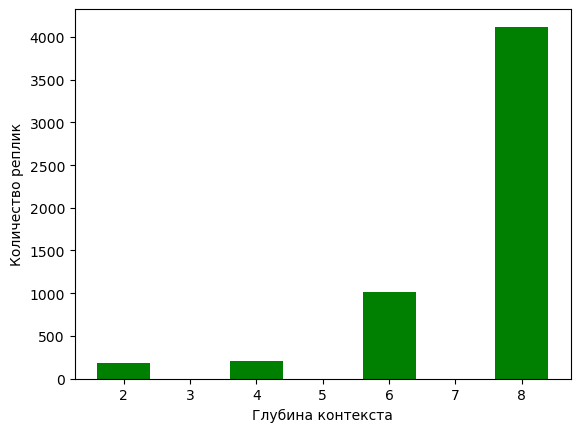

In [41]:
plt.ylabel('Количество реплик')
plt.xlabel('Глубина контекста')
plt.bar(len_cont.keys(), len_cont.values(), color='g');

In [42]:
try:
    os.mkdir(DATA_FOLDER)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'data'


In [43]:
with open(os.path.join(DATA_FOLDER, 'data.pkl'), 'wb') as file:
    pickle.dump(data, file)